In [1]:
import cv2
import numpy as np
import pandas as pd
from skimage import filters
from skimage.filters import gabor_kernel
from scipy.ndimage import convolve
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm

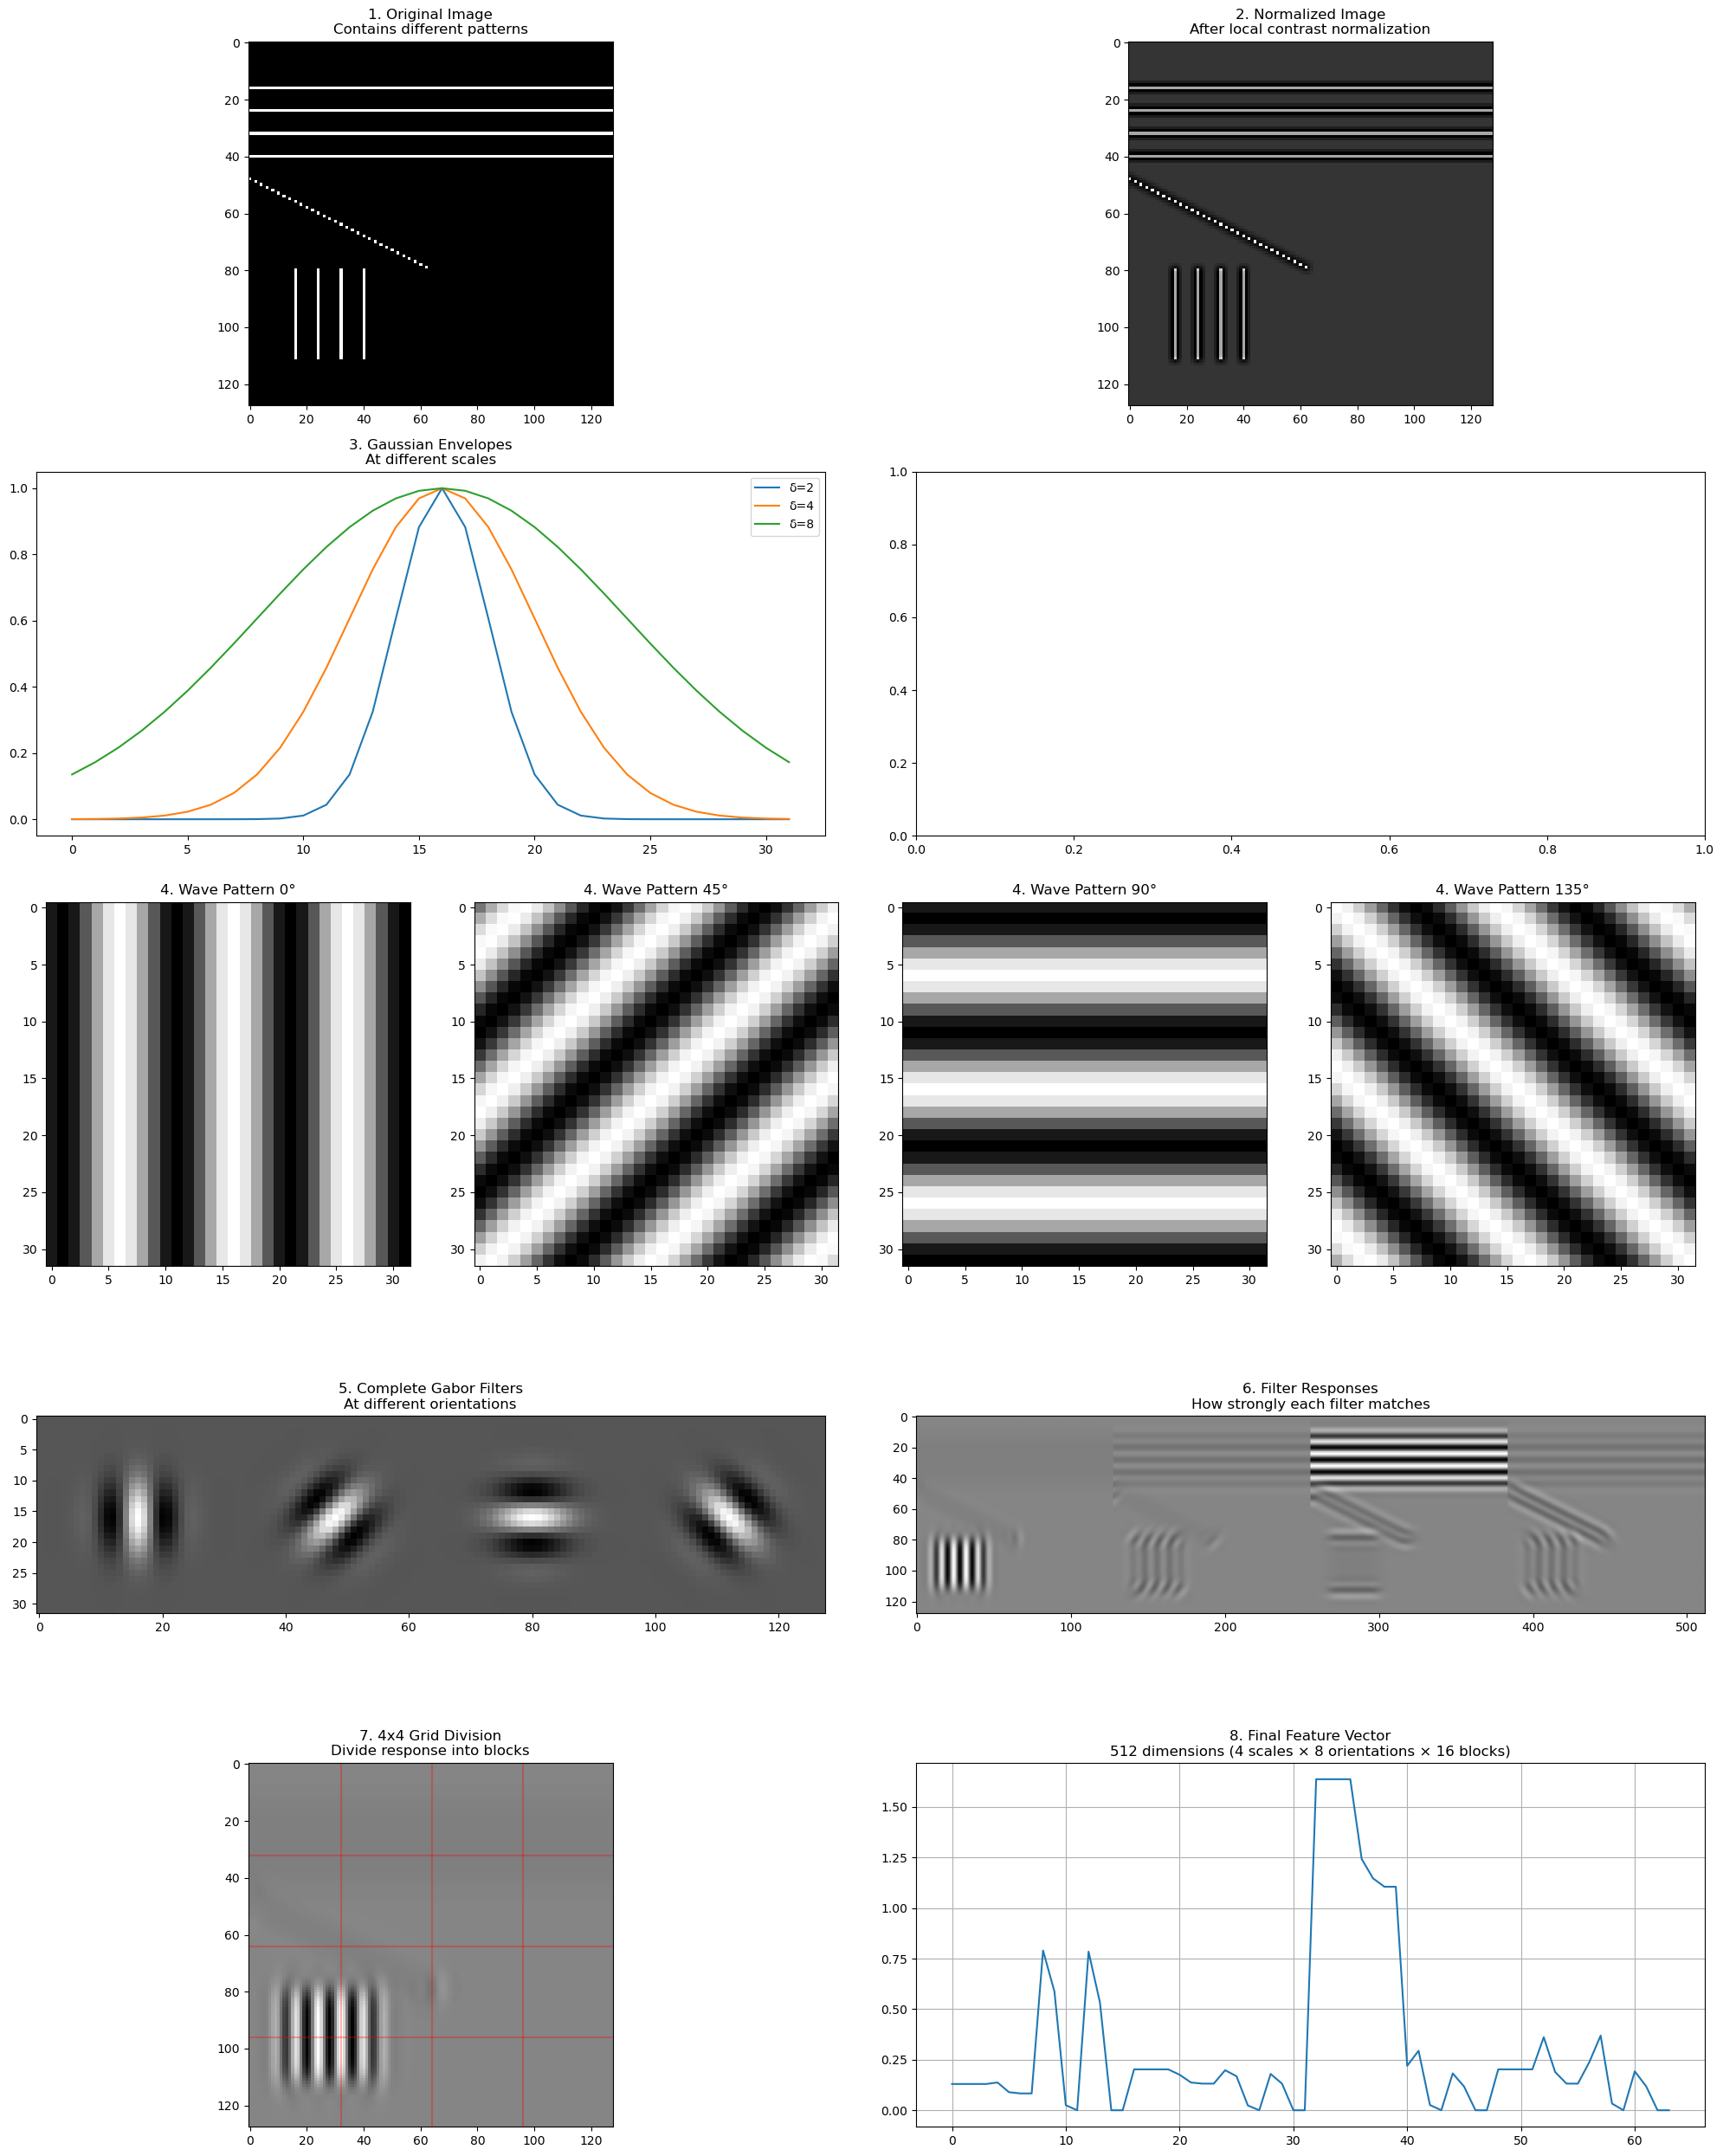

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_gist_process():
    size = 128
    image = np.zeros((size, size))
    # Add horizontal lines in top half
    image[16:48:8, :] = 1
    # Add vertical lines in bottom half
    image[80:112, 16:48:8] = 1
    # Add diagonal pattern in middle
    for i in range(size):
        if 48 <= i < 80:
            j = (i - 48) * 2
            if 0 <= j < size:
                image[i, j] = 1

    plt.figure(figsize=(20, 25))
    
    # 1. Image Preprocessing
    plt.subplot(521)
    plt.imshow(image, cmap='gray')
    plt.title('1. Original Image\nContains different patterns')
    
    # Local contrast normalization
    local_mean = cv2.GaussianBlur(image, (5, 5), 1.0)
    local_std = np.sqrt(cv2.GaussianBlur(image**2, (5, 5), 1.0) - local_mean**2)
    normalized = (image - local_mean) / (local_std + 1e-8)
    
    plt.subplot(522)
    plt.imshow(normalized, cmap='gray')
    plt.title('2. Normalized Image\nAfter local contrast normalization')
    
    # 2. Gabor Filter Creation
    y, x = np.mgrid[-16:16, -16:16]
    
    # Show Gaussian envelopes at different scales
    plt.subplot(523)
    deltas = [2, 4, 8]
    for delta in deltas:
        gaussian = np.exp(-0.5 * (x**2 + y**2)/delta**2)
        plt.plot(gaussian[16], label=f'δ={delta}')
    plt.title('3. Gaussian Envelopes\nAt different scales')
    plt.legend()
    
    # Show wave patterns at different orientations
    plt.subplot(524)
    angles = [0, 45, 90, 135]
    for idx, angle in enumerate(angles):
        theta = np.radians(angle)
        u0 = 0.1 * np.cos(theta)
        v0 = 0.1 * np.sin(theta)
        wave = np.cos(2*np.pi*(u0*x + v0*y))
        plt.subplot(5,4,9+idx)
        plt.imshow(wave, cmap='gray')
        plt.title(f'4. Wave Pattern {angle}°')
    
    # 3. Complete Gabor Filters
    delta = 4
    plt.subplot(527)
    filters = []
    for angle in angles:
        theta = np.radians(angle)
        u0 = 0.1 * np.cos(theta)
        v0 = 0.1 * np.sin(theta)
        gaussian = np.exp(-0.5 * (x**2 + y**2)/delta**2)
        wave = np.exp(-2j*np.pi*(u0*x + v0*y))
        gabor = gaussian * wave
        filters.append(np.real(gabor))
    
    combined_filters = np.hstack(filters)
    plt.imshow(combined_filters, cmap='gray')
    plt.title('5. Complete Gabor Filters\nAt different orientations')
    
    # 4. Filter Responses
    plt.subplot(528)
    responses = []
    for gabor in filters:
        response = cv2.filter2D(normalized, cv2.CV_32F, gabor)
        responses.append(response)
    
    combined_responses = np.hstack(responses)
    plt.imshow(combined_responses, cmap='gray')
    plt.title('6. Filter Responses\nHow strongly each filter matches')
    
    # 5. Grid Division
    plt.subplot(529)
    # Show grid lines on one response
    response = responses[0]
    plt.imshow(response, cmap='gray')
    grid_size = size // 4
    for i in range(1, 4):
        plt.axhline(y=i*grid_size, color='r', linestyle='-', alpha=0.3)
        plt.axvline(x=i*grid_size, color='r', linestyle='-', alpha=0.3)
    plt.title('7. 4x4 Grid Division\nDivide response into blocks')
    
    # 6. Feature Vector
    plt.subplot(5,2,10)
    # Create a sample feature vector visualization
    features = []
    for response in responses:
        for i in range(4):
            for j in range(4):
                block = response[i*grid_size:(i+1)*grid_size, 
                               j*grid_size:(j+1)*grid_size]
                features.append(np.mean(np.abs(block)))
    
    features = np.array(features)
    plt.plot(features)
    plt.title('8. Final Feature Vector\n512 dimensions (4 scales × 8 orientations × 16 blocks)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

visualize_gist_process()

In [3]:
def create_gabor_filter(size, u0, v0, delta_x, delta_y):
    #size: kernel size
    #u0, v0: spatial frequency points
    #delta_x, delta_y: spatial scales

    y, x = np.mgrid[-size//2:size//2, -size//2:size//2]
    
    gaussian = np.exp(-0.5 * (x**2/delta_x**2 + y**2/delta_y**2))

    sinusoid = np.exp(-2j * np.pi * (u0*x + v0*y))
    
    return gaussian * sinusoid


In [11]:
def compute_gist_descriptor(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
        
    image = cv2.resize(image, (128, 128))
    image = image.astype(np.float32) / 255.0
    
    local_mean = cv2.GaussianBlur(image, (5, 5), 1.0)
    local_std = np.sqrt(cv2.GaussianBlur(image**2, (5, 5), 1.0) - local_mean**2)
    image = (image - local_mean) / (local_std + 1e-8)
    
    features = []
    scales = [2, 4, 8, 16]
    orientations = 8
    
    for delta in scales:
        for theta in range(orientations):
            angle = theta * np.pi / orientations
            u0 = np.cos(angle) / delta
            v0 = np.sin(angle) / delta
            
            gabor_filter = create_gabor_filter(
                size=31,
                u0=u0,
                v0=v0,
                delta_x=delta,
                delta_y=delta
            )
            
            filtered = cv2.filter2D(image, cv2.CV_32F, np.real(gabor_filter))
            
            block_h = image.shape[0] // 4
            block_w = image.shape[1] // 4
            
            for i in range(4):
                for j in range(4):
                    block = filtered[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
                    energy = np.mean(np.abs(block))
                    features.append(energy)
    
    return np.array(features)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_waves():
    # Time array
    t = np.linspace(0, 2*np.pi, 200)
    
    # Different frequencies
    low_freq = np.sin(t)        # Low frequency wave
    high_freq = np.sin(10 * t)  # High frequency wave
    
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.title('Low Frequency Wave')
    plt.plot(t, low_freq)
    
    plt.subplot(2,1,2)
    plt.title('High Frequency Wave')
    plt.plot(t, high_freq)
    
    plt.tight_layout()
    plt.show()

# Gabor filter visualization
def visualize_gabor_filter():
    # Create Gabor kernel
    kernel = cv2.getGaborKernel(
        (31, 31),   # Kernel size
        theta=np.pi/4,  # Orientation
        sigma=10.0,     # Gaussian standard deviation
        lambd=10.0,     # Wavelength
        gamma=0.5,      # Spatial aspect ratio
        psi=0           # Phase offset
    )
    
    plt.imshow(kernel, cmap='gray')
    plt.title('Gabor Filter Kernel')
    plt.show()

visualize_waves()

In [10]:
def process_directory(base_path):
    all_features = []
    all_labels = []
    
    image_paths = []
    for root, dirs, files in os.walk(base_path):
        if 'Negative' in root:
            continue
        category = os.path.basename(root)
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append((os.path.join(root, file), category))
    
    for image_path, category in tqdm(image_paths, desc="Processing"):
        features = compute_gist_descriptor(image_path)
        if features is not None:
            all_features.append(features)
            all_labels.append(category)
    
    df = pd.DataFrame(all_features)
    df['category'] = all_labels
    df['label'] = df['category'].astype('category').cat.codes
    
    return df